In [16]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
#from sklearn.metrics import mean_squared_error
#from scipy.stats import norm
#from scipy.optimize import curve_fit
#from scipy.optimize import fsolve
import matplotlib.pyplot as plt
#%matplotlib inline+
import folium
import json
import urllib.request

url_B = "https://data.brasil.io/dataset/covid19/caso.csv.gz"
url_G = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

In [17]:
df = pd.read_csv(url_B, sep = ",")

In [ ]:
req = urllib.request.urlopen(url_G)
content = req.read().decode('ansi')

geo = json.loads(content)

In [18]:
df_hoje = df.loc[df['is_last'] == True, :]

label = ["Dia", "Estado", "Casos Confirmados", "Óbitos Confirmados", "Incidência de Casos", "Mortalidade"]
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']

In [19]:
FMT = '%Y-%m-%d'

date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)

In [20]:
df_estados = df.loc[df['city'].isnull(), :].drop(['city', 'place_type', 'city_ibge_code', 'order_for_place'], axis = 1)
df_estados.reset_index(drop = True, inplace = True)

df_Brasil = df_estados.drop(['is_last', 'estimated_population_2019', 'confirmed_per_100k_inhabitants', 'death_rate'], axis = 1)
df_Brasil = df_Brasil.groupby('date').sum()

In [21]:
df_cidades = df.loc[df['place_type'].eq('city'), :].drop(['place_type', 'order_for_place'], axis = 1)
df_paraiba = df_cidades.loc[df_cidades['state'].eq('PB'), :].drop(['state'], axis = 1)
df_paraiba.reset_index(drop = True, inplace = True)

In [22]:
df_PB = []

paraiba_c = list(df_paraiba.sort_values("confirmed", ascending = False)['city'].unique())
df_PB = paraiba_c

for c in range(len(paraiba_c)) :
    df_PB[c] = df_paraiba.loc[df_paraiba['city'] == paraiba_c[c], :].drop(['estimated_population_2019'], axis = 1)
    df_PB[c] = df_PB[c].sort_values('date', ascending = True)
    df_PB[c].reset_index(drop = True, inplace = True)
    
paraiba_c = list(df_paraiba.sort_values("confirmed", ascending = False)['city'].unique())

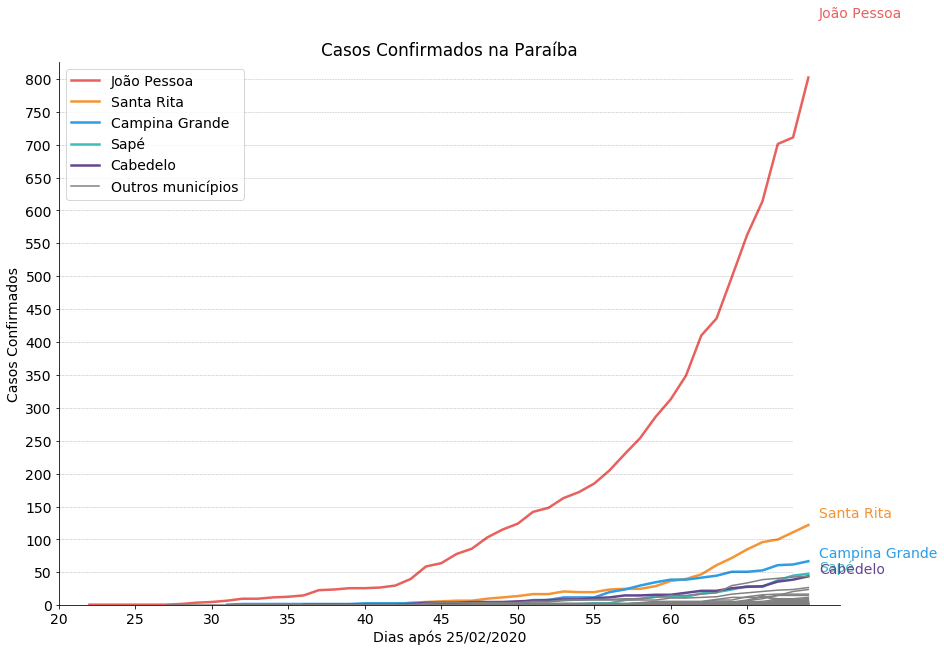

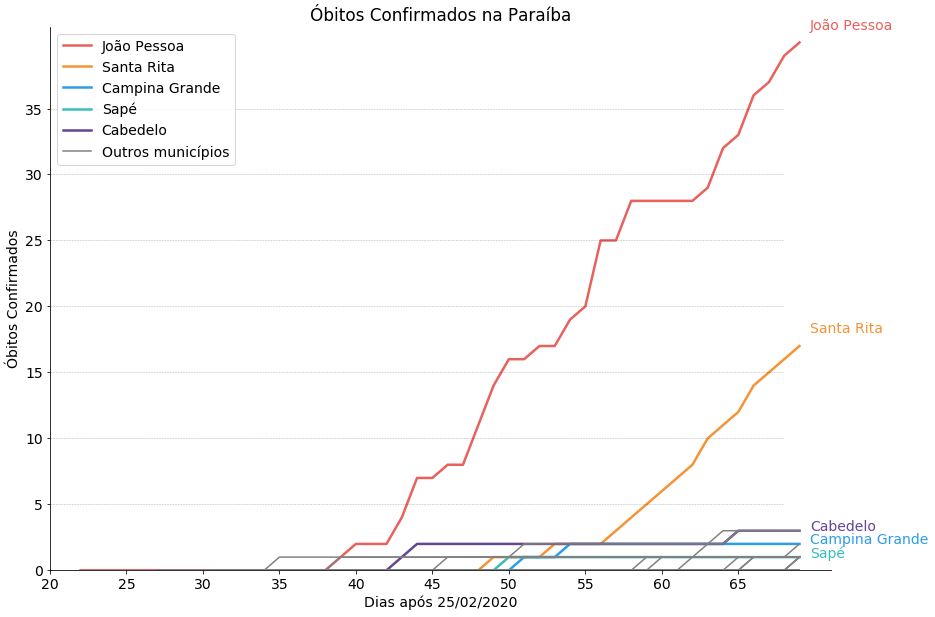

In [23]:
for f in range(2, 4) :
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]
    plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                    labelbottom = "on", left = "off", right = "off", labelleft = "on")
    
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    
    x_max = 0
    y_max = 0
    
    for c in range(len(paraiba_c)) :

        # Real data
        x = list(df_PB[c].iloc[:, 0])
        y = list(df_PB[c].iloc[:, f])
        
        if max(x) > x_max :
            x_max = max(x)
        if max(y) > y_max :
            y_max = max(y)
  
        if c < 5 :
            plt.plot(x, y, marker = ' ', label = paraiba_c[c], color = color[c], lw = 2.5)
            plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), paraiba_c[c], color = color[c], fontsize = 14)
        elif c == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = 'gray', lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = 'gray', lw = 1.5)
      
        if f == 2 :
            ytick = 50
        else :
            ytick = 5
    
    plt.yticks(range(0, y_max, ytick), fontsize=14)    
    plt.xticks(range(0, x_max, 5), fontsize = 14)
    
    for t in range(0, y_max, ytick) :    
         plt.plot(range(20, x_max), [t] * len(range(20, x_max)), linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

    plt.xlim(20, x_max * 1.03)
    plt.ylim(0, y_max * 1.03)
    plt.title(label[f] + " na Paraíba")
    plt.legend(loc = 2)
    #plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig(label[f] + " COVID19 Paraiba.png")
    plt.show()

In [ ]:
df_hoje = df.loc[(df["is_last"] == True), :].drop(['date', 'is_last'], axis = 1)
df_hoje = df_hoje.loc[(df_hoje["place_type"] == 'city'), :]
df_hoje = df_hoje.loc[(df_hoje["city"] != 'Importados/Indefinidos'), :]
df_hoje['city_ibge_code'] = df_hoje['city_ibge_code'].astype(int).astype(str)

In [ ]:
bins = list(df_hoje['confirmed'].quantile([0, 0.97, 0.99, 0.998, 1]))

mapa_casos = folium.Map(
    width = 800, height = 500,
    location = [-15.77972, -47.92972], #[-7, -36.75], # centro paraiba 
    zoom_start = 4,
    tiles = 'cartodbpositron'
)

mapa_casos.choropleth(
    geo_data = geo,
    name = 'choropleth',
    data = df_hoje,
    columns = ['city_ibge_code', 'confirmed'],
    key_on = 'feature.properties.id',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados',
    legend_fontsize = '14',
    bins = [0, 10, 100, 1000, 10000, 30000]
)
folium.LayerControl().add_to(mapa_casos)

mapa_casos.save('index.html')
mapa_casos

In [24]:
df_UF = []

estados = list(df_estados.sort_values("confirmed", ascending = False)['state'].unique())
df_UF = estados

for e in range(27) :
    df_UF[e] = df_estados.loc[df_estados['state'] == estados[e], :].drop(['estimated_population_2019', 'is_last'], axis = 1)
    df_UF[e] = df_UF[e].sort_values('date', ascending = True)
    df_UF[e].reset_index(drop = True, inplace = True)
    
estados = list(df_estados.sort_values("confirmed", ascending = False)['state'].unique())

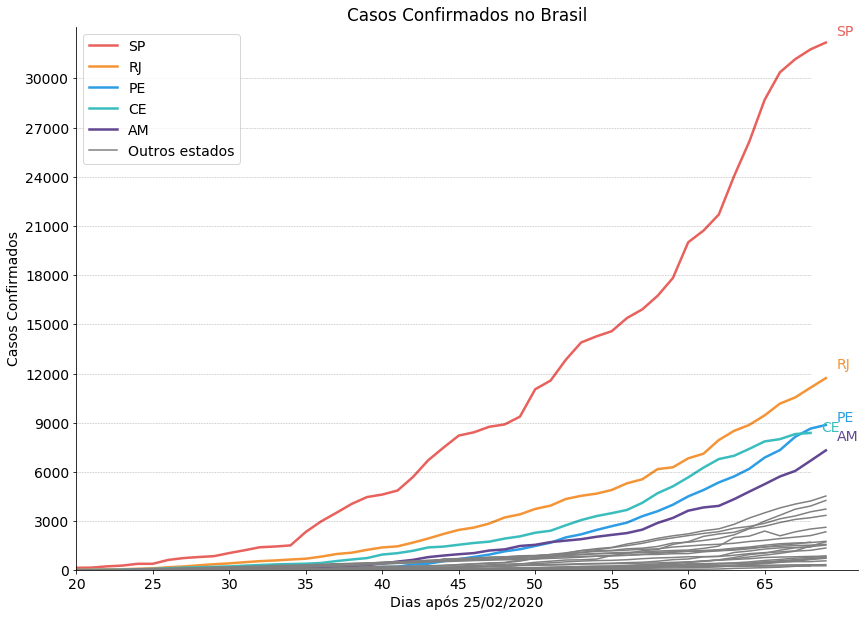

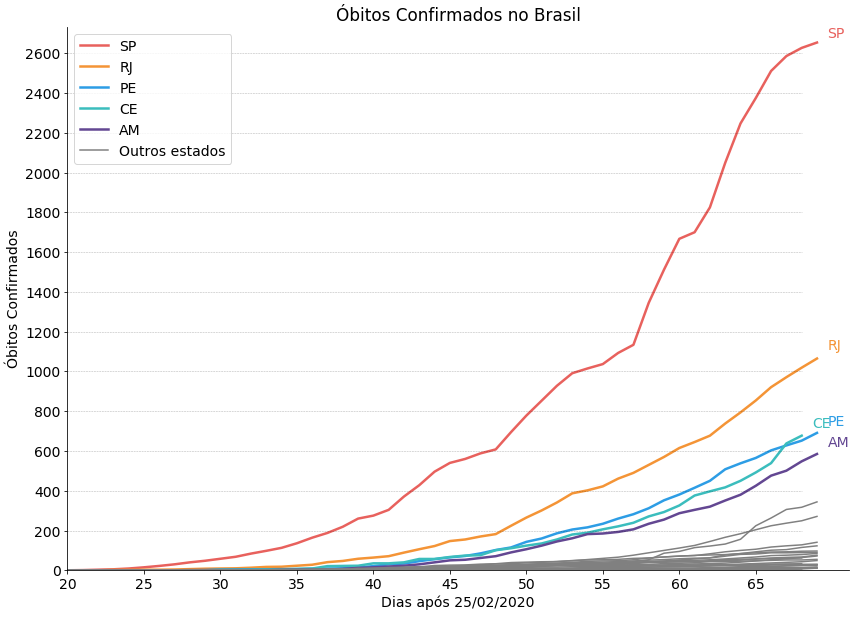

In [25]:
label = ["Dia", "Estado", "Casos Confirmados", "Óbitos Confirmados", "Incidência de Casos", "Mortalidade"]
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']

for f in range(2, 4) :
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]
    plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                    labelbottom = "on", left = "off", right = "off", labelleft = "on")
    
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    
    # Brasil data
#     x = range(max(df_Brasil.index))
#     y = list(df_Brasil.iloc[x, f - 2])
#     plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
#     plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), "Brasil", color = "black", fontsize = 14)
    
    x_max = max(x)
    y_max = max(y)
    for e in range(27) :

        # Real data
        x = list(df_UF[e].iloc[:, 0])
        y = list(df_UF[e].iloc[:, f])
        
        if max(x) > x_max :
            x_max = max(x)
        if max(y) > y_max :
            y_max = max(y)
  
        if e < 5 :
            plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
            plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), estados[e], color = color[e], fontsize = 14)
        elif e == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros estados', color = 'gray', lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = 'gray', lw = 1.5)
            
    ytick = 1000 * int(0.0001 * y_max)
    if ytick == 0 : 
        ytick = 100 * int(0.001 * y_max)
   
    plt.yticks(range(0, y_max, ytick), fontsize=14)    
    plt.xticks(range(0, x_max, 5), fontsize = 14)
    
    for t in range(0, y_max, ytick) :    
         plt.plot(range(20, x_max), [t] * len(range(20, x_max)), linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

    plt.xlim(20, x_max * 1.03)
    plt.ylim(0, y_max * 1.03)
    plt.title(label[f] + " no Brasil")
    plt.legend(loc = 2)
    #plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig(label[f] + " COVID19 Brasil.png")
    plt.show()

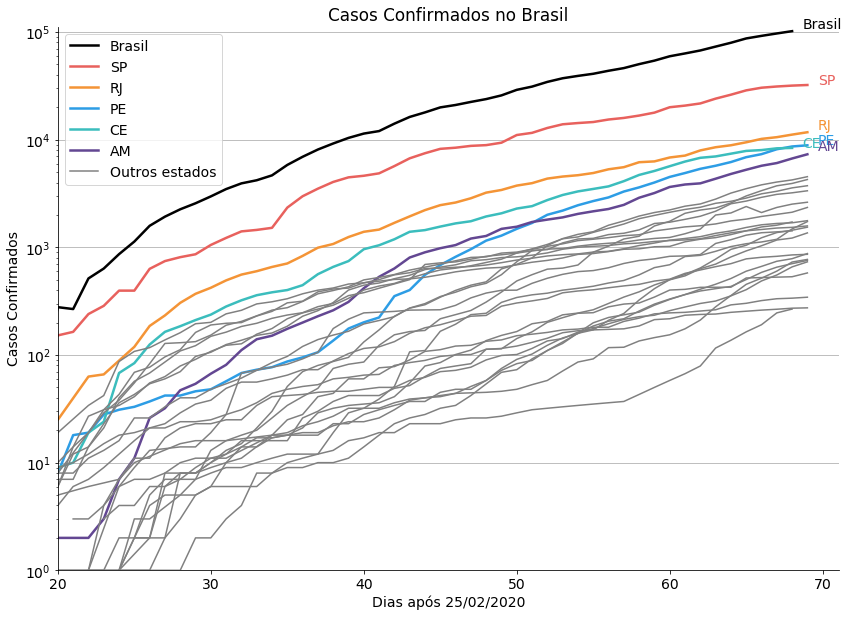

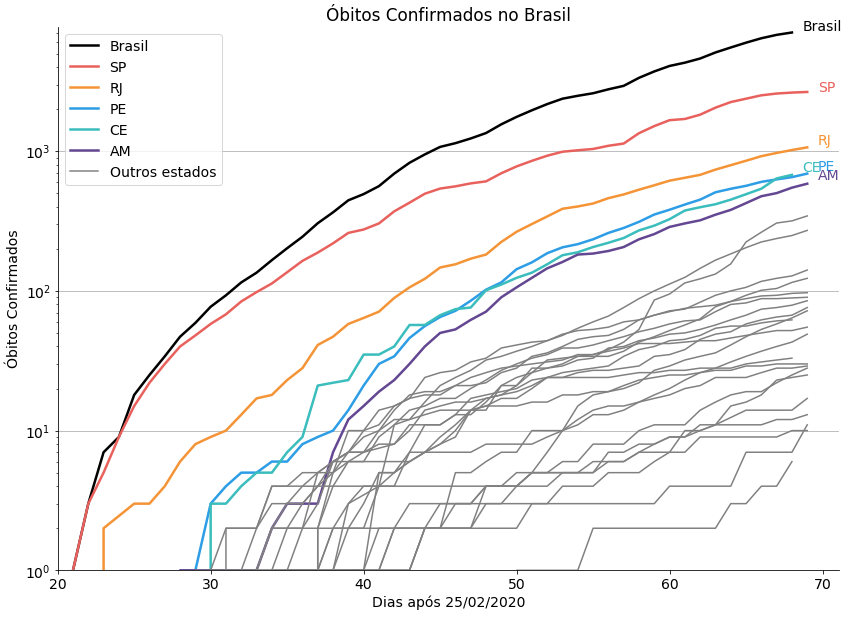

In [26]:
label = ["Dia", "Estado", "Casos Confirmados", "Óbitos Confirmados", "Incidência de Casos", "Mortalidade"]
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']

for f in range(2, 4) :
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]
    #plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
    #                labelbottom = "on", left = "off", right = "off", labelleft = "on")
    
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y')
    # Brasil data
    x = range(max(df_Brasil.index))
    y = list(df_Brasil.iloc[x, f - 2])
    plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
    plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), "Brasil", color = "black", fontsize = 14)
    
    x_max = max(x)
    y_max = max(y)
    for e in range(27) :

        # Real data
        x = list(df_UF[e].iloc[:, 0])
        y = list(df_UF[e].iloc[:, f])
        
        if max(x) > x_max :
            x_max = max(x)
        if max(y) > y_max :
            y_max = max(y)
  
        if e < 5 :
            plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
            plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), estados[e], color = color[e], fontsize = 14)
        elif e == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros estados', color = 'gray', lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = 'gray', lw = 1.5)

    plt.xlim(20, x_max * 1.03)
    plt.ylim(1, y_max * 1.1)
    plt.title(label[f] + " no Brasil")
    plt.legend(loc = 2)
    plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig(label[f] + " COVID19 Brasil log.png")
    plt.show()
